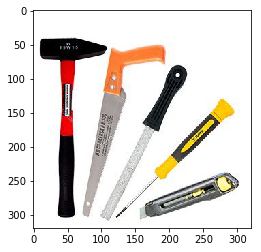

In [201]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import prettytable as pt
import math
%matplotlib inline
num_max = 3


num = []
max1 = max2 = max3 = 0
num1 = num2 = num3 = -1


def get_rect():
    return cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
img = cv.imread(r"13.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

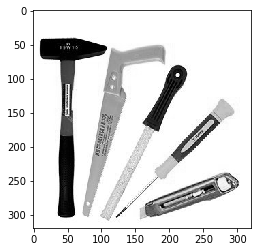

In [202]:
img_colorless = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
plt.imshow(img_colorless, cmap = 'gray')

 Применим фильтр для размытия

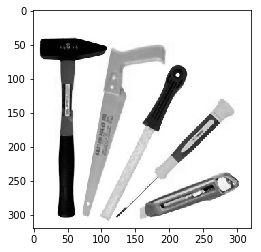

In [203]:
gray = cv.medianBlur(img_colorless, 3)
plt.imshow(gray, cmap = 'gray')

Проводим адаптивную бинаризацию

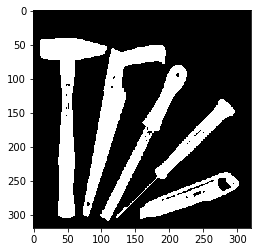

In [204]:
ret2,img_binarised = cv.threshold(gray,125,255,cv.THRESH_BINARY +cv.THRESH_OTSU)#
adaptive = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C + cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 163, 1)
plt.imshow(adaptive, cmap = 'gray')

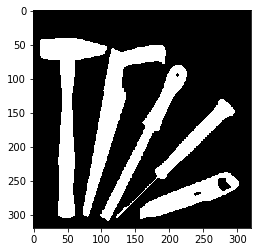

In [205]:
closing = cv.morphologyEx(adaptive, cv.MORPH_CLOSE, get_rect())
plt.imshow(closing, cmap = 'gray')

Разбиваем на компоненты связности и выводим таблицу основных характеристик

In [206]:
nlabels, labels, stats, centroids =(cv.connectedComponentsWithStats(closing))

tablesOfComponents = pt.PrettyTable()
tablesOfComponents.field_names = ["Component", "Area(pixels)", "Bounding box(left, width, height)", "Center"]
for _ in range(nlabels - 1):
    i = _ + 1
    BB = []
    BB.append(format(stats[i, cv.CC_STAT_LEFT], '.2f'))    
    BB.append(format(stats[i, cv.CC_STAT_WIDTH], '.2f'))
    BB.append(format(stats[i, cv.CC_STAT_HEIGHT], '.2f'))

    center = []
    center.append(format(centroids[i][0], '.2f'))
    center.append(format(centroids[i][1], '.2f'))
    tablesOfComponents.add_row([i, format(stats[_, cv.CC_STAT_AREA],'.2f'), BB, center])

print(tablesOfComponents)

+-----------+--------------+-----------------------------------+----------------------+
| Component | Area(pixels) | Bounding box(left, width, height) |        Center        |
+-----------+--------------+-----------------------------------+----------------------+
|     1     |   76679.00   |    ['10.00', '99.00', '264.00']   | ['50.55', '145.02']  |
|     2     |   7347.00    |   ['73.00', '122.00', '253.00']   | ['119.28', '145.64'] |
|     3     |   6968.00    |   ['99.00', '127.00', '228.00']   | ['166.85', '183.02'] |
|     4     |   4496.00    |   ['122.00', '174.00', '175.00']  | ['233.78', '191.77'] |
|     5     |   3145.00    |   ['157.00', '146.00', '69.00']   | ['228.08', '272.92'] |
+-----------+--------------+-----------------------------------+----------------------+


Ищем 3 контура с наибольшими периметрами, запоминаем их метки

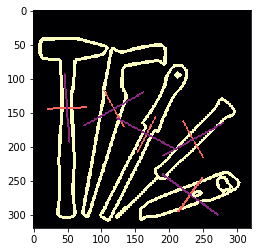

In [211]:
perimeters = []
areas = []
circularity = []
centroids_c = []
orientations = []
eccentricity = []
new_im = np.zeros(closing.shape, dtype="uint8")

msk3 = 0
for i in range(1, nlabels):

    msk = labels == i
    msk1 = np.zeros(msk.shape, dtype="uint8")
    for i1 in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            if msk[i1, j] == True:
                msk1[i1, j] = int(1)
            else:
                msk1[i1, j] = int(0)
    msk3 = msk1[:]
    im21, contours1, hierarchy1 = cv.findContours(msk1, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    p0 = per_i = 0.95 * cv.arcLength(contours1[0], True)


    if p0 > max1:
        num3 = num2
        max3 = max2
        num2 = num1
        max2 = max1

        num1 = i
        max1 = p0
    elif p0 > max2:
        num3 = num2
        max3 = max2
        num2 = i
        max2 = p0
    elif p0 > max3:
        num3 = i
        max3 = p0
 
    # Начало работы с моментами и геометрическими характеристиками     
    for j in range(len(contours1)):    
        cont = contours1[j]
        #получаем моменты контура
        M = cv.moments(cont)
        
        #считаем центры масс (Burge, "Core Algorithms", p.37)
        Centroids = []
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        centroids_c.append([cx, cy])
        
        #(Burge, "Core Algorithms", p.42)
        eccentricity_i = (M['m20'] + M['m02'] + math.sqrt((M['m20'] - M['m02'])**2 + 4 * M['m11']**2))  / (M['m20'] + M['m02'] - math.sqrt((M['m20'] - M['m02'])**2 + 4 * M['m11']**2))
        eccentricity.append(eccentricity_i)
        
        #(Burge, "Core Algorithms", p.40)
        theta = 0.5 * math.atan2((2 * M['m11']) , (M['m20']- M['m02']))       
        theta = (theta / math.pi) * 180
        orientations.append(theta)
        
        xd = math.cos(theta)   
        yd = math.sin(theta)
        
        xd1 = math.cos(theta - math.pi / 2)   
        yd1 = math.sin(theta - math.pi / 2)
        
        #рисуем сами контуры    
        cv.drawContours(new_im, cont, -1, (255, 255, 255), 3)
        
        #рисуем оси для "основных" контуров
        if j == 0:        
            cv.line(new_im,(int(cx - 30 * xd), int(cy - 30 * yd)),(int(cx + 30 * xd), int(cy + 30 * yd)), (173, 216, 230), 2)
            cv.line(new_im,(int(cx - 50 * xd1), int(cy - 50 * yd1)),(int(cx + 50 * xd1), int(cy + 50 * yd1)), (100, 120, 125), 2)
   
        ellipse = cv.fitEllipse(cont)
        #cv.ellipse(new_im, ellipse, (243, 43, 43), 2)
        
        #считаем периметр контура
        per_i = 0.95 * cv.arcLength(cont, True)
        perimeters.append(per_i)
        
        #считаем площадь
        ar1 = cv.contourArea(cont)
        areas.append(ar1) 
        
        #(Burge, "Core Algorithms", p.34)
        if not (per_i == 0):
            circularity_i = 4 * np.pi * ar1 / per_i ** 2
        else:
            circularity_i = 0
   
        circularity.append(circularity_i)   
    
    plt.imshow(new_im, cmap = 'magma')        
   

In [208]:
x = pt.PrettyTable()
x.field_names = ["Contour", "Perimeter", "Area", "Circularity", "Centroid", "Eccentricity", "Orientation angle"]
for _, s in enumerate(perimeters):
    x.add_row([_, format(perimeters[_],'.2f'), format(areas[_], '.2f'), format(circularity[_], '.2f'),  centroids_c[_], format(eccentricity[_], '.2f'), format(orientations[_], '.2f')])


print(x)

+---------+-----------+---------+-------------+------------+--------------+-------------------+
| Contour | Perimeter |   Area  | Circularity |  Centroid  | Eccentricity | Orientation angle |
+---------+-----------+---------+-------------+------------+--------------+-------------------+
|    0    |   672.99  | 7006.50 |     0.19    | [50, 144]  |    31.98     |       75.34       |
|    1    |   658.08  | 6651.50 |     0.19    | [119, 145] |     9.92     |       54.48       |
|    2    |   549.33  | 4273.00 |     0.18    | [167, 182] |    13.30     |       49.17       |
|    3    |   18.35   |  24.00  |     0.90    | [212, 95]  |   31756.15   |       24.14       |
|    4    |   492.95  | 2950.00 |     0.15    | [235, 190] |    37.62     |       38.77       |
|    5    |   341.26  | 3898.00 |     0.42    | [231, 271] |    86.65     |       49.32       |
|    6    |   29.42   |  53.00  |     0.77    | [240, 269] |   16394.11   |       48.21       |
|    7    |   62.09   |  275.50 |     0.

Отрисовываем 3 контура с наибольшими периметрами
Производим сглаживание границ 
Рисуем выпуклую оболочку

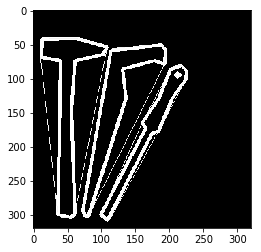

In [218]:
num.append(num1)
num.append(num2)
num.append(num3)

new_im2 = np.zeros(closing.shape, dtype="uint8")


for i in range(0, 3):
    msk = np.zeros(closing.shape, dtype="uint8")
    msk = labels == num[i]
    msk1 = np.zeros(msk.shape, dtype="uint8")
    for i1 in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            if msk[i1, j] == True:
                msk1[i1, j] = int(1)
            else:
                msk1[i1, j] = int(0)
    im21, contours1, hierarchy1 = cv.findContours(msk1, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    for j in range(len(contours1)):
        cont = contours1[j]
        peri = cv.arcLength(cont, True)
        approx = cv.approxPolyDP(cont, peri * 0.006, True)  
        cv.drawContours(new_im2, [approx], -1, (255, 255, 255), 3)
        hull = cv.convexHull(cont)
        cv.drawContours(new_im2, [hull], -1, (243, 43, 43), 1)
        
plt.imshow(new_im2, cmap = 'gray')          